In [174]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import cv2
import json
np.random.seed(0)

This jupyter notebook takes data from the Serengeti json file and then reformats it in an acceptable manner for Yolov5 to train.

First of all, below imports everything in the appropriate csv files. 
They probably will not be used in the making of this .ipynb

In [93]:
data_path = 'physicshub_dir/dfs6/pub/hackathon/DATASETS/SERENGETI/DOWNLOADED'
id_to_path = pd.read_csv('Serengeti_Image_Subset.csv')
annotated = pd.read_csv('Serengeti_Annotations_Subset.csv')

This loads the json file that contains the boudning box annotations of the Serengeti Dataset

In [94]:
file = open('SnapshotSerengetiBboxes_20190903.json')
bbox = json.load(file)
file.close()

This code is meant to retrieve image_path of the dataset

In [95]:
def retrieve_imagepath(capture_id: str, id_to_path: 'Pandas DataFrame') -> 'image':
    #this assumes id_to_path dataframe has 'capture_id' column and 'image_path_rel' column
    return id_to_path.loc[id_to_path['capture_id'] == capture_id]['image_path_rel'][0]

In [96]:
retrieve_imagepath(annotated['capture_id'][0], id_to_path)

'S1/B04/B04_R1/S1_B04_R1_PICT0001.JPG'

Retrieves teh bbox image from the data given the json and data_path.

In [100]:
def bbox_image_retrieval(bbox_data: 'bbox->json->annotations->indexed', data_path: str) -> 'image':
    return cv2.imread(f'{data_path}/{bbox_data}.JPG')

In [292]:
test = bbox_image_retrieval(bbox['annotations'][0]['image_id'], data_path)

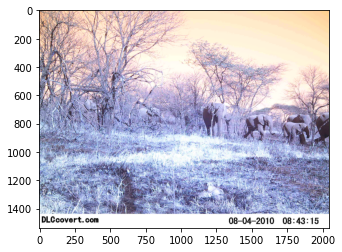

In [293]:
plt.imshow(test)

This is the meat of the code that will do the reformatting of the bbox data and image.

Yolov5 will take two folders data and labels.

data will include im0.jpg im1.jpg im2.jpg ... etc.
it will also inlcude im0.txt im1.txt im2.txt ...etc.
Each corresponding txt file is labels for the jpg file.

In [290]:
def format_bbox_txt(bbox_info, write_index):
        cat_id = bbox_info['category_id']
        x,y,w,h = map(int, list(bbox_info['bbox']))
        x_center = x+w/2
        y_center = y+h/2
        file = open(f'bbox_labels/im{write_index}.txt', 'a+')
        file.write(f'{cat_id} {x_center} {y_center} {w} {h}\r\n')
        file.close()

def input_data(bbox_data, data_num=100):
    annot_list = np.arange(0,len(bbox_data))
    count = 0
    write_index = 0
    im_set = set()
    for index, im_id in enumerate(annot_list[:data_num]):
        img_path = bbox_data[im_id]['image_id']
        img_str = img_path.split('/')[-1]
        
        
        img = cv2.imread(f'{data_path}/{img_path}.JPG')
        if type(img)!=type(None):
            size = len(im_set)
            im_set |= {img_str}

            if len(im_set) != size or size==0:
                write_index += 1
                cv2.imwrite(f'bbox_data/im{write_index}.JPG', img)

            format_bbox_txt(bbox_data[im_id], write_index)
        else:
            count+=1

Testing the code out on Cluster

In [291]:
input_data(bbox['annotations'],data_num=500)

In [ ]:
Next up, writing bounding box code in r

In [175]:
def draw_boundingbox(img, bbox_data):
    x,y,w,h = map(int, bbox_data['bbox'])
    img = cv2.line(img,(x,y),(x+w,y),(0,255,0), 3)
    img = cv2.line(img,(x,y),(x,y+h),(0,255,0), 3)
    img = cv2.line(img,(x+w,y),(x+w,y+h),(0,255,0),3)
    img = cv2.line(img,(x,y+h),(x+w,y+h),(0,255,0),3)
    plt.imshow(img)

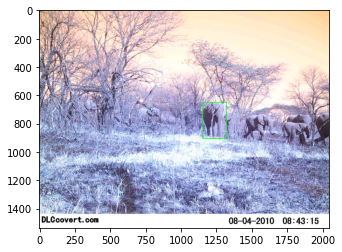

In [176]:
img = bbox_image_retrieval(bbox['annotations'][3]['image_id'], data_path)
draw_boundingbox(img, bbox['annotations'][3])

In [154]:
bbox['annotations'][0]['image_id']

'S1/B05/B05_R1/S1_B05_R1_PICT0056'

In [229]:
file = open('yolo.txt', 'a+')
file.write('YOLOR\r\n')
file.close()